# To do:
- Machine Learning: investigate Facebook's Prophet library 
- Learn more about time series analysis

In [1]:
### Imports ###
from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
from urllib.request import urlretrieve
from datetime import datetime
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
import os # for deleting files
import calendar

In [2]:
import statsmodels.api as sm # for decomposition
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20

In [26]:
### Get data ###
def get_data(location_input):
    '''
    Returns data for desired location
    Parameters:
    location - write a string of location wanted. Will only work with 'Derby' currently
    '''
    ### DICTIONARY OF DATA FROM DIFFERENT PLACES!
    Derby = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv'
    }
    Reading = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2017.csv'
    }
    Nottingham_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2017.csv'
    }
    Burton_On_Trent_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2018.csv'  
    } # no 2017 data for Burton
    
    # Turning above dictionaries into one dictionary
    data_locations = {
      "Derby" : Derby,
      "Reading" : Reading,
      "Nottingham_Centre" : Nottingham_Centre,
      "Burton_Centre" : Burton_On_Trent_Centre
    }

    global df_2020, df_2019, df_2018, df_2017,location_string
    location_string = location_input # for plot titles
    
    # Getting URLs for requested location
    URL_2020 = data_locations[location_input]['2020']
    URL_2019 = data_locations[location_input]['2019']
    URL_2018 = data_locations[location_input]['2018']
    URL_2017 = data_locations[location_input]['2017']
    # Save URLs to .csv files
    urlretrieve(URL_2020,'alex_data_2020.csv')
    urlretrieve(URL_2019,'alex_data_2019.csv')
    urlretrieve(URL_2018,'alex_data_2018.csv')
    urlretrieve(URL_2017,'alex_data_2017.csv')
    # Get dataframes from .csv files
    df_2020 = pd.read_csv('alex_data_2020.csv',skiprows=4) # (skipping top 4 rows as they're empty)
    df_2019 = pd.read_csv('alex_data_2019.csv',skiprows=4)
    df_2018 = pd.read_csv('alex_data_2018.csv',skiprows=4)
    df_2017 = pd.read_csv('alex_data_2017.csv',skiprows=4)
    unit = 'ugm^3'
    # Delete the .csv files
    os.remove('alex_data_2020.csv')
    os.remove('alex_data_2019.csv')
    os.remove('alex_data_2018.csv')
    os.remove('alex_data_2017.csv')
    
    print('Successfully got data for {}!'.format(location_input))

In [27]:
get_data('Derby')

Successfully got data for Derby!


In [28]:
### Cleaning data ###
# Issue with the data: 
# what should be "02-01-2020" and "00:00" is called "01-01-2020"  and "24:00" which Pandas doesn't like
# Need to take every instance where this happens and + 1 to the date and replace 24:00 with 00:00
def datetime_cleaner(variable):
    '''
    Function to take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00
    Also removes redundant columns
    Doesn't set the index to the datetime though
    '''
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y')
    variable['Date'] = pd.to_datetime(variable['Date'])
    # date + 1 for every 24th entry 
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value
    # cleaning up columns and data types in a really janky way
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00')
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    variable.drop(['Date','time','status','unit','status.1','unit.1','status.2','unit.2','Date String','Date Time String'],
                 axis=1,inplace=True)
    
        ### Would be great to say "if unit.3 exists then remove it" etc, as I think Reading data has this 
    
    # Adding new features
    variable['Week'] = variable['Date Time'].dt.week
    variable['Day Of Week'] = variable['Date Time'].dt.dayofweek
    variable['Quarter'] = variable['Date Time'].dt.quarter
    variable['Month'] = variable['Date Time'].dt.month
    variable['Weekday Or Weekend'] = np.where(variable['Day Of Week'] >=5,'Weekend','Weekday')
    variable['Total'] = variable['Nitric oxide'] + variable['Nitrogen dioxide']
    # setting index to be the date time
    variable.index = variable['Date Time']

datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]
df_all = pd.concat(frames)
df_all.index = df_all['Date Time']

In [6]:
df_2020.tail()

Nitric oxide  Nitrogen dioxide  \
Date Time                                             
2020-04-09 20:00:00       2.49460          16.25625   
2020-04-09 21:00:00       2.24514          17.59500   
2020-04-09 22:00:00       1.62149          11.85750   
2020-04-09 23:00:00       0.87311           8.03250   
2020-04-10 00:00:00       0.62365           6.50250   

                     Nitrogen oxides as nitrogen dioxide           Date Time  \
Date Time                                                                      
2020-04-09 20:00:00                             20.08125 2020-04-09 20:00:00   
2020-04-09 21:00:00                             21.03750 2020-04-09 21:00:00   
2020-04-09 22:00:00                             14.34375 2020-04-09 22:00:00   
2020-04-09 23:00:00                              9.37125 2020-04-09 23:00:00   
2020-04-10 00:00:00                              7.45875 2020-04-10 00:00:00   

                     Week  Day Of Week  Quarter  Month Weekday Or Weekend  \
Date Time                                                                   
2020-04-09 20:00:00    15            3        2      4            Weekday   
2020-04-09 21:00:00    15            3        2      4            Weekday   
2020-04-09 22:00:00    15            3        2      4            Weekday   
2020-04-09 23:00:00    15            3        2      4            Weekday   
2020-04-10 00:00:00    15            4        2      4            Weekday   

                        Total  
Date Time                      
2020-04-09 20:00:00  18.75085  
2020-04-09 21:00:00  19.84014  
2020-04-09 22:00:00  13.47899  
2020-04-09 23:00:00   8.90561  
2020-04-10 00:00:00   7.12615

# Exploratory data analysis

In [7]:
# function to let you decide date range to plot, resample type, line or bar, and aggregate type
def plot_date_range(start,end,resample_string,plottype,aggregate):
    '''
    Parameters:
    start = date string in format YYYY-MM-DD
    end = date string in format YYYY-MM-DD
    resample_string = string of 'H'/'D'/'W'/'M'
    plottype = string 'line' or 'bar'
    aggregate = string 'sum','average','median'
    '''
    resample_string = resample_string.upper() # just in case user were to input h instead of H
    
    matplotlib.rcParams['axes.labelsize'] = 20
    matplotlib.rcParams['xtick.labelsize'] = 200
    matplotlib.rcParams['ytick.labelsize'] = 200
    
    # for title of chart
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
    
    # dates to plot 
    start = datetime.strptime(start,'%Y-%m-%d')
    end = datetime.strptime(end,'%Y-%m-%d')
    plt.style.use('seaborn')
    # resampling based on input
    if resample_string == 'H':
        z = df_all.loc[start:end]
        if plottype == 'line':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        elif plottype == 'bar':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot.bar(figsize=(15,10))
        x.set_title('Hourly Emissions Between {} and {}'.format(start,end))
        x.set_ylim(0)
    else:    
        z = df_all.loc[start:end]
        if plottype == 'line':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot(figsize=(15,10))
            x.set_title('{} {} Emissions Between {} and {} for {}'.format(aggregate.title(),title_string,start,end,location_string))
            x.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot.bar(figsize=(15,10))
            x.set_title('{} {} Emissions Between {} and {} for {}'.format(aggregate.title(),title_string,start,end,location_string))
            x.set_ylim(0)
            
            #plt.xticks(np.arange(3),['Jan 2020','Feb 2020','Mar 2020'])
            #plt.xticks(rotation=1)
            #plt.title('Monthly Emissions in 2020')
            #plt.xlabel('')
            plt.ylabel('Total Emissions Measured (ugm$^3$)')
            plt.legend(loc='upper left')

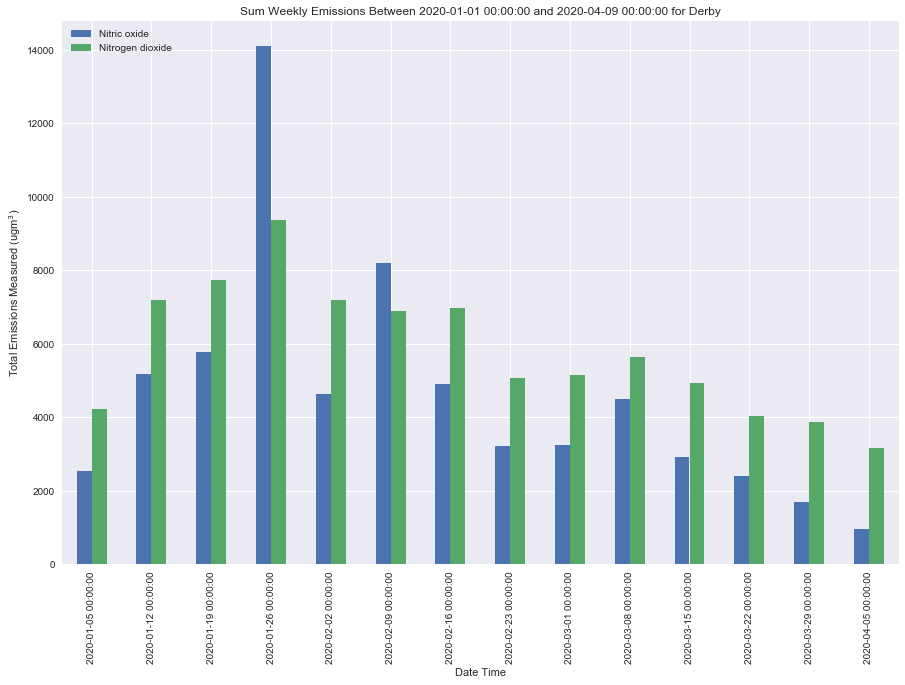

In [148]:
plot_date_range(start='2020-01-01',end='2020-04-09',resample_string='W',plottype='bar',aggregate='sum')

In [ ]:
# for radio derby
# official lockdown happened in week 13 monday
# it's now halfway through week 15
# so i can look at week 13 and week 14

In [12]:
df_all.tail()

Nitric oxide  Nitrogen dioxide  \
Date Time                                             
2020-04-09 20:00:00       2.49460          16.25625   
2020-04-09 21:00:00       2.24514          17.59500   
2020-04-09 22:00:00       1.62149          11.85750   
2020-04-09 23:00:00       0.87311           8.03250   
2020-04-10 00:00:00       0.62365           6.50250   

                     Nitrogen oxides as nitrogen dioxide           Date Time  \
Date Time                                                                      
2020-04-09 20:00:00                             20.08125 2020-04-09 20:00:00   
2020-04-09 21:00:00                             21.03750 2020-04-09 21:00:00   
2020-04-09 22:00:00                             14.34375 2020-04-09 22:00:00   
2020-04-09 23:00:00                              9.37125 2020-04-09 23:00:00   
2020-04-10 00:00:00                              7.45875 2020-04-10 00:00:00   

                     Week  Day Of Week  Quarter  Month Weekday Or Weekend  \
Date Time                                                                   
2020-04-09 20:00:00    15            3        2      4            Weekday   
2020-04-09 21:00:00    15            3        2      4            Weekday   
2020-04-09 22:00:00    15            3        2      4            Weekday   
2020-04-09 23:00:00    15            3        2      4            Weekday   
2020-04-10 00:00:00    15            4        2      4            Weekday   

                        Total  
Date Time                      
2020-04-09 20:00:00  18.75085  
2020-04-09 21:00:00  19.84014  
2020-04-09 22:00:00  13.47899  
2020-04-09 23:00:00   8.90561  
2020-04-10 00:00:00   7.12615

# Rolling summary

(0, 771552.0495884996)

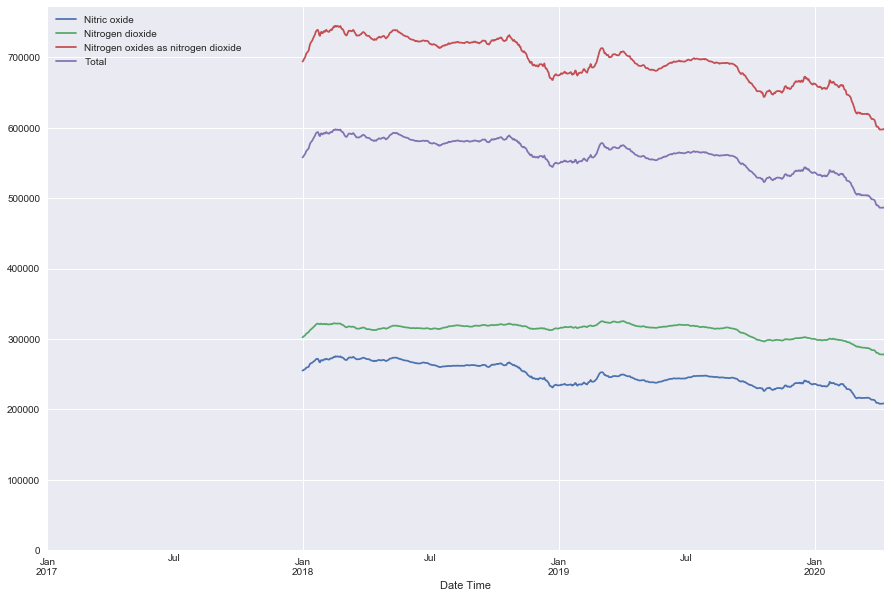

In [20]:
plt.style.use('seaborn')
ax = df_all[['Nitric oxide','Nitrogen dioxide',
              'Nitrogen oxides as nitrogen dioxide',
             'Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])
ax.set_ylim(0,None)

(0, 603347.9390065002)

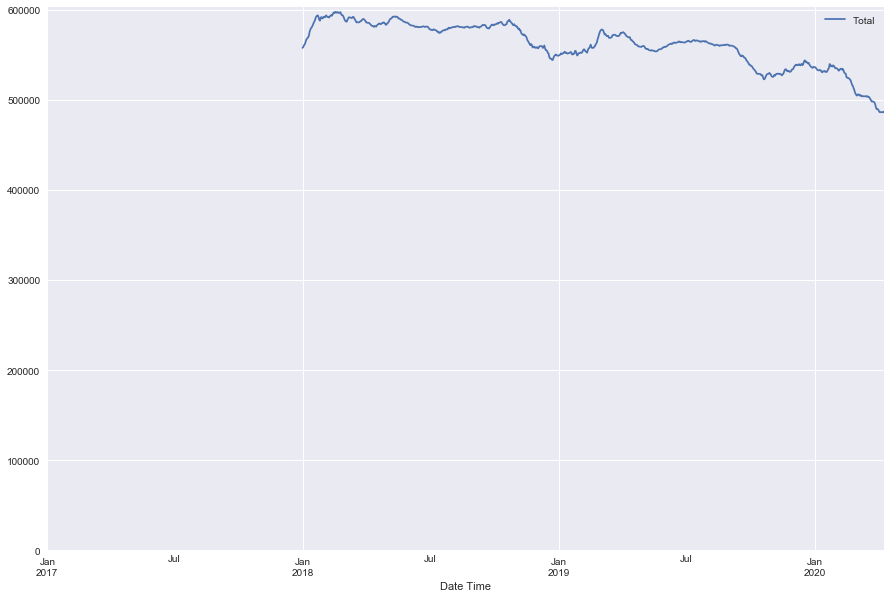

In [21]:
plt.style.use('seaborn')
ax = df_all[['Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])
ax.set_ylim(0,None)

(480585.9775635006, 603347.9390065002)

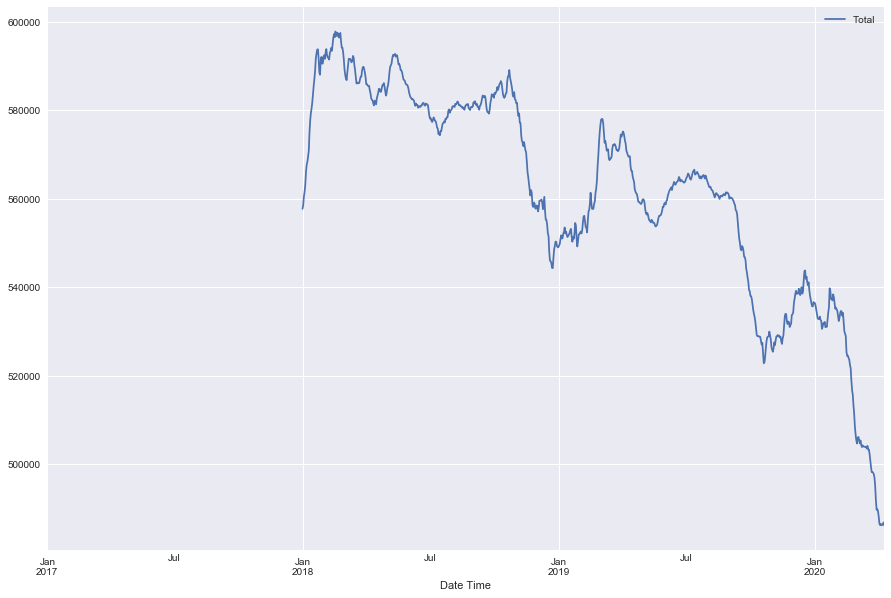

In [22]:
plt.style.use('seaborn')
ax = df_all[['Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])
ax.set_ylim(None,None) # sets limits to be min and max of the data

## Groupby to assess pollution per hour

Text(0.5, 1.0, 'Average pollution per hour (all data since records began)')

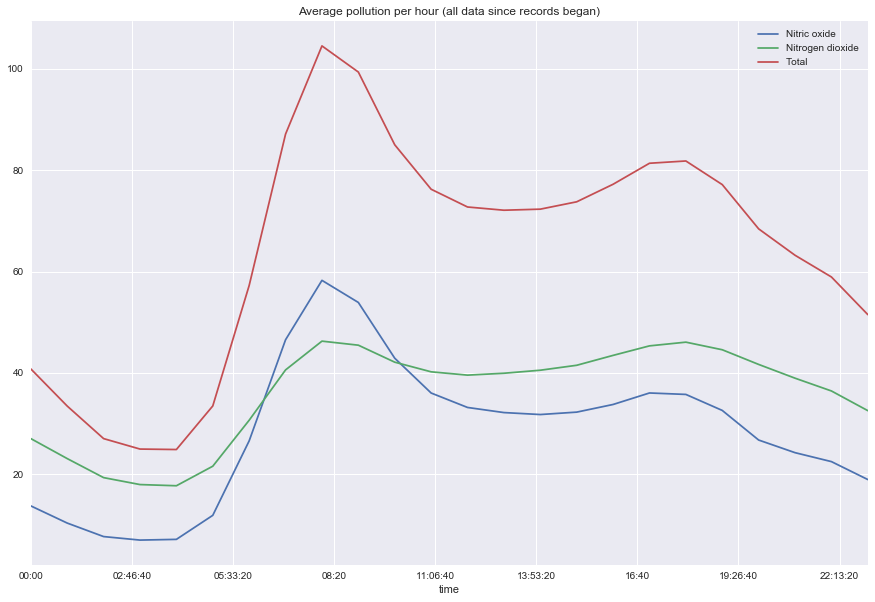

In [23]:
df_all[['Nitric oxide','Nitrogen dioxide','Total']
      ].groupby(df_all[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10])
plt.title('Average pollution per hour (all data since records began)')

Text(0.5, 1.0, 'Average pollution per hour in 2020')

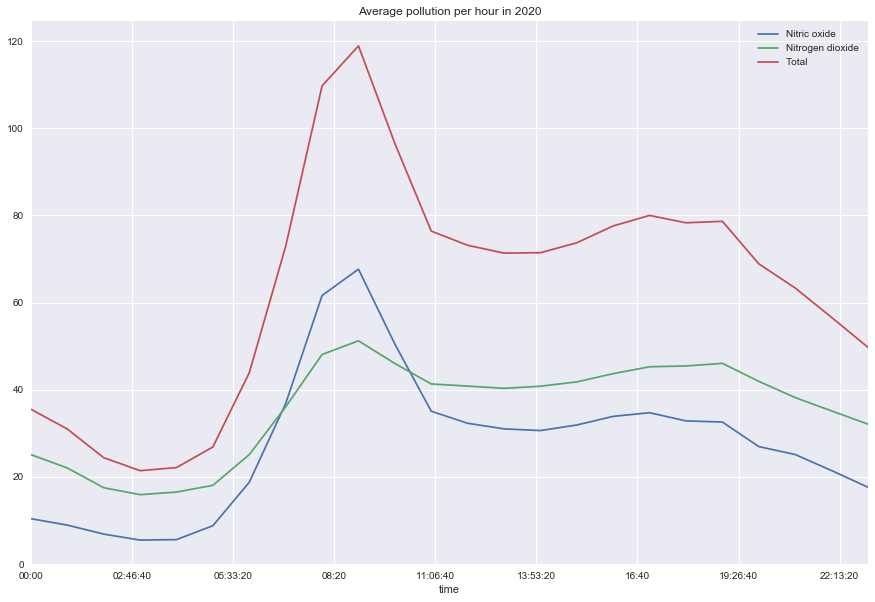

In [24]:
df_2020[['Nitric oxide','Nitrogen dioxide','Total']
      ].groupby(df_2020[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10])
plt.title('Average pollution per hour in 2020')

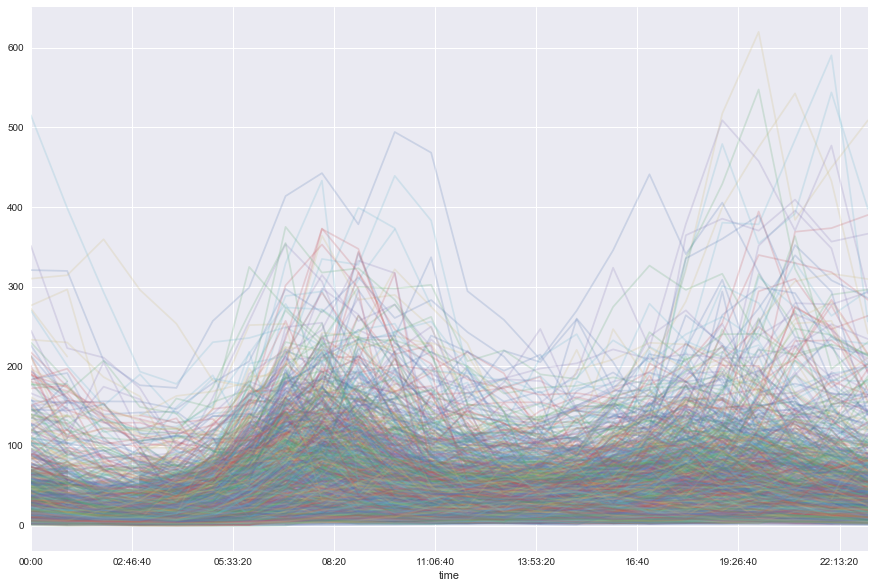

In [10]:
# mental thing plotting all days hourly pollution
pivoted = df_all.pivot_table('Total',index=df_all.index.time,columns=df_all.index.date)
pivoted.plot(legend=False,alpha=0.2,figsize=[15,10])

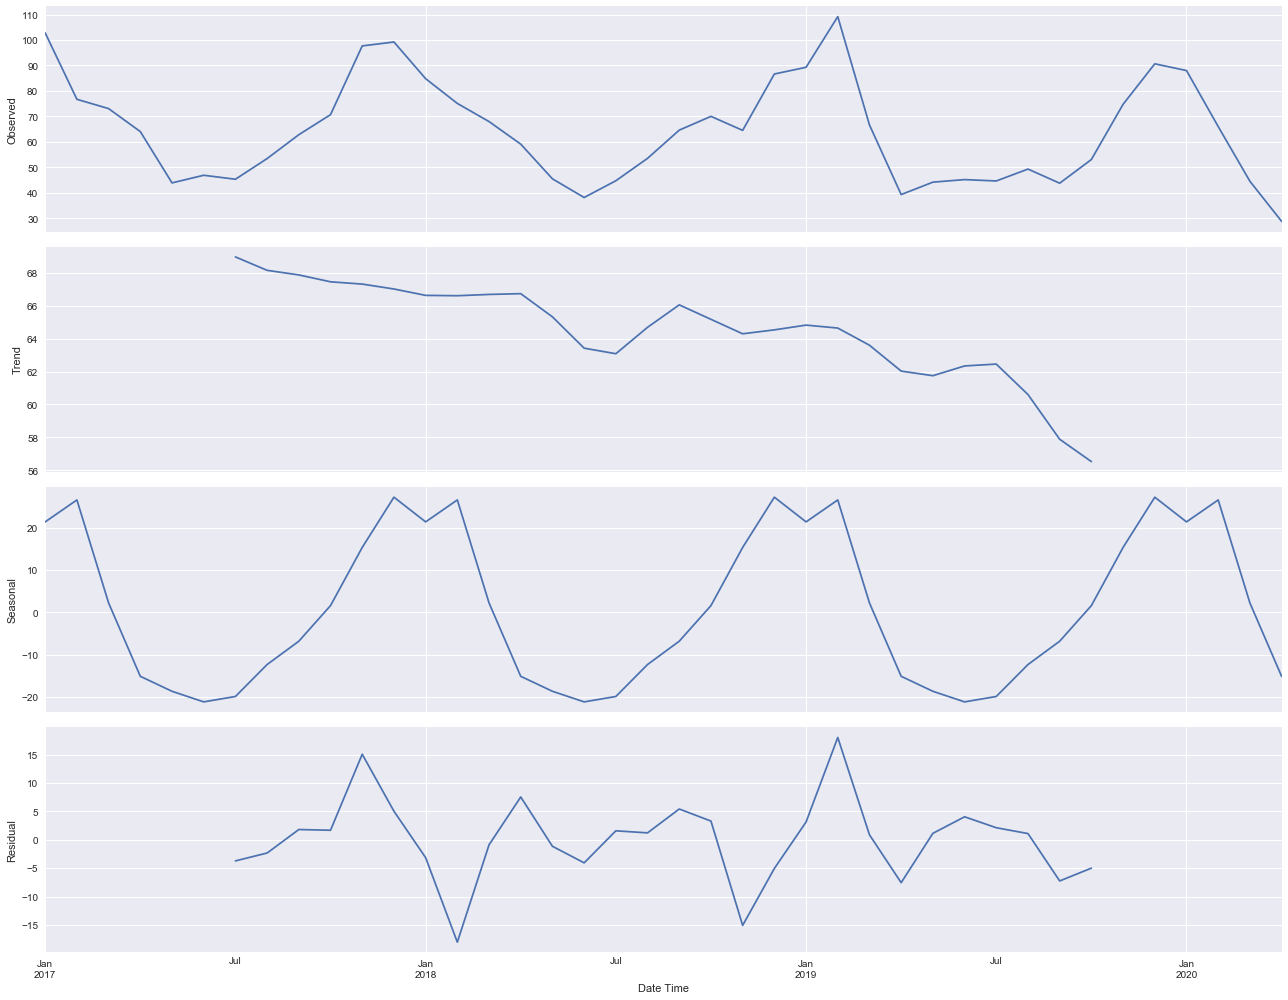

In [27]:
# I've never learned about decomposition so I don't fully understand this, just found the code online

from pylab import rcParams
rcParams['figure.figsize'] = 18, 14

y = df_all['Total'].resample('M').mean()

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
z = decomposition.plot()


# Comparing multiple years on one plot

In [150]:
# Note - only really works for hourly and daily, although daily is only one that's useful 
# The below code is hideous but the function works well! 
def year_comparison(start,end,resample_string,years_of_data):
    global df_2020, df_2019, df_2018, df_2017
    '''
    Parameters:
    start = string of date in format 'MM-DD'
    end = string of date in format 'MM-DD'
    resample_string = 'H','D','W','M'
    years_of_data = 1, 2, 3 or 4, determines how many years to plot
    '''
   
    # below is hideous but I'm just doing it in this dumb way because I know it'll work
    # gets you start and end dates for each year
    start_2020 = '2020-' + start
    start_2020 = pd.to_datetime(start_2020)
    end_2020 = '2020-' + end
    end_2020 = pd.to_datetime(end_2020)
    
    start_2019 = '2019-' + start
    start_2019 = pd.to_datetime(start_2019)
    end_2019 = '2019-' + end
    end_2019 = pd.to_datetime(end_2019)
       
    start_2018 = '2018-' + start
    start_2018 = pd.to_datetime(start_2018)
    end_2018 = '2018-' + end
    end_2018 = pd.to_datetime(end_2018)
    
    start_2017 = '2017-' + start
    start_2017 = pd.to_datetime(start_2017)
    end_2017 = '2017-' + end
    end_2017 = pd.to_datetime(end_2017)
    
    ### MASKS ###
    # 2020
    mask = (df_2020['Date Time'] >= start_2020) & (df_2020['Date Time'] <= end_2020) # REPLACE MASKS WITH .LOC!
    df_2020_ = df_2020.loc[mask]
    # 2019
    mask = (df_2019['Date Time'] >= start_2019) & (df_2019['Date Time'] <= end_2019) # REPLACE MASKS WITH .LOC!
    df_2019_ = df_2019.loc[mask]
    # 2018
    mask = (df_2018['Date Time'] >= start_2018) & (df_2018['Date Time'] <= end_2018) # REPLACE MASKS WITH .LOC!
    df_2018_ = df_2018.loc[mask]
    # 2017
    mask = (df_2017['Date Time'] >= start_2017) & (df_2017['Date Time'] <= end_2017) # REPLACE MASKS WITH .LOC!
    df_2017_ = df_2017.loc[mask]
    
    if resample_string=='H':
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_['Date Time'].dt.strftime('%m-%d %H:%M')

        ### Plotting them with date time no year
        plt.figure(figsize=(15,10))
        
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                        label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                        label = '2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'],
                        label ='2017 Nitrix Oxide',alpha=0.6,linestyle='-.',color='#EC4E20')
        
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                    label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                        label = '2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')
    
        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                    label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            
        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                    label = '2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
    
        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xlabel('')
        plt.ylabel('Nitric oxide (ugm$^3$)')
        plt.title('Hourly Total Nitric Oxide Emmisions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')
        plt.xticks('')
    
    elif resample_string!='H':
        ### Resample accordingly (however only by day works)
        plt.figure(figsize=(15,10))
        df_2020_ = df_2020_.resample(resample_string).sum()
        df_2019_ = df_2019_.resample(resample_string).sum()
        df_2018_ = df_2018_.resample(resample_string).sum()
        df_2017_ = df_2017_.resample(resample_string).sum()
                
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_.index.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_.index.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_.index.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_.index.strftime('%m-%d %H:%M')
        
        #### Replacing date time as index as removing datatime column 
        def cleaner(variable):
            variable.index = variable['Date Time No Year']

        cleaner(df_2020_)
        cleaner(df_2019_)
        cleaner(df_2018_)
        cleaner(df_2017_)

        plt.figure(figsize=(15,10))
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                         label='2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                         label='2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'],
                         label='2017 Nitric Oxide',alpha=0.6,linestyle='-.',color='#EC4E20')
            
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                         label='2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                         label='2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')

        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                         label='2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')

        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')

        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xlabel('')
        plt.ylabel('Nitric oxide (ugm$^3$)')
        plt.title('Daily Total Nitric Oxide Emmisions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')


<Figure size 1080x720 with 0 Axes>

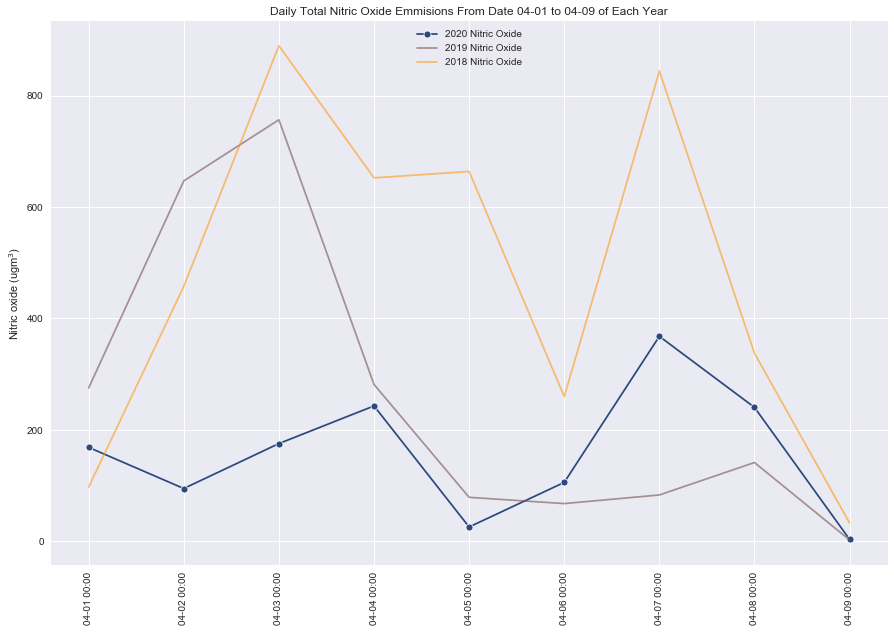

In [152]:
year_comparison(start='04-01',end='04-09',resample_string='D',years_of_data=3) 
# would be great to be able to specify what years to plot

## Plot each year by week number

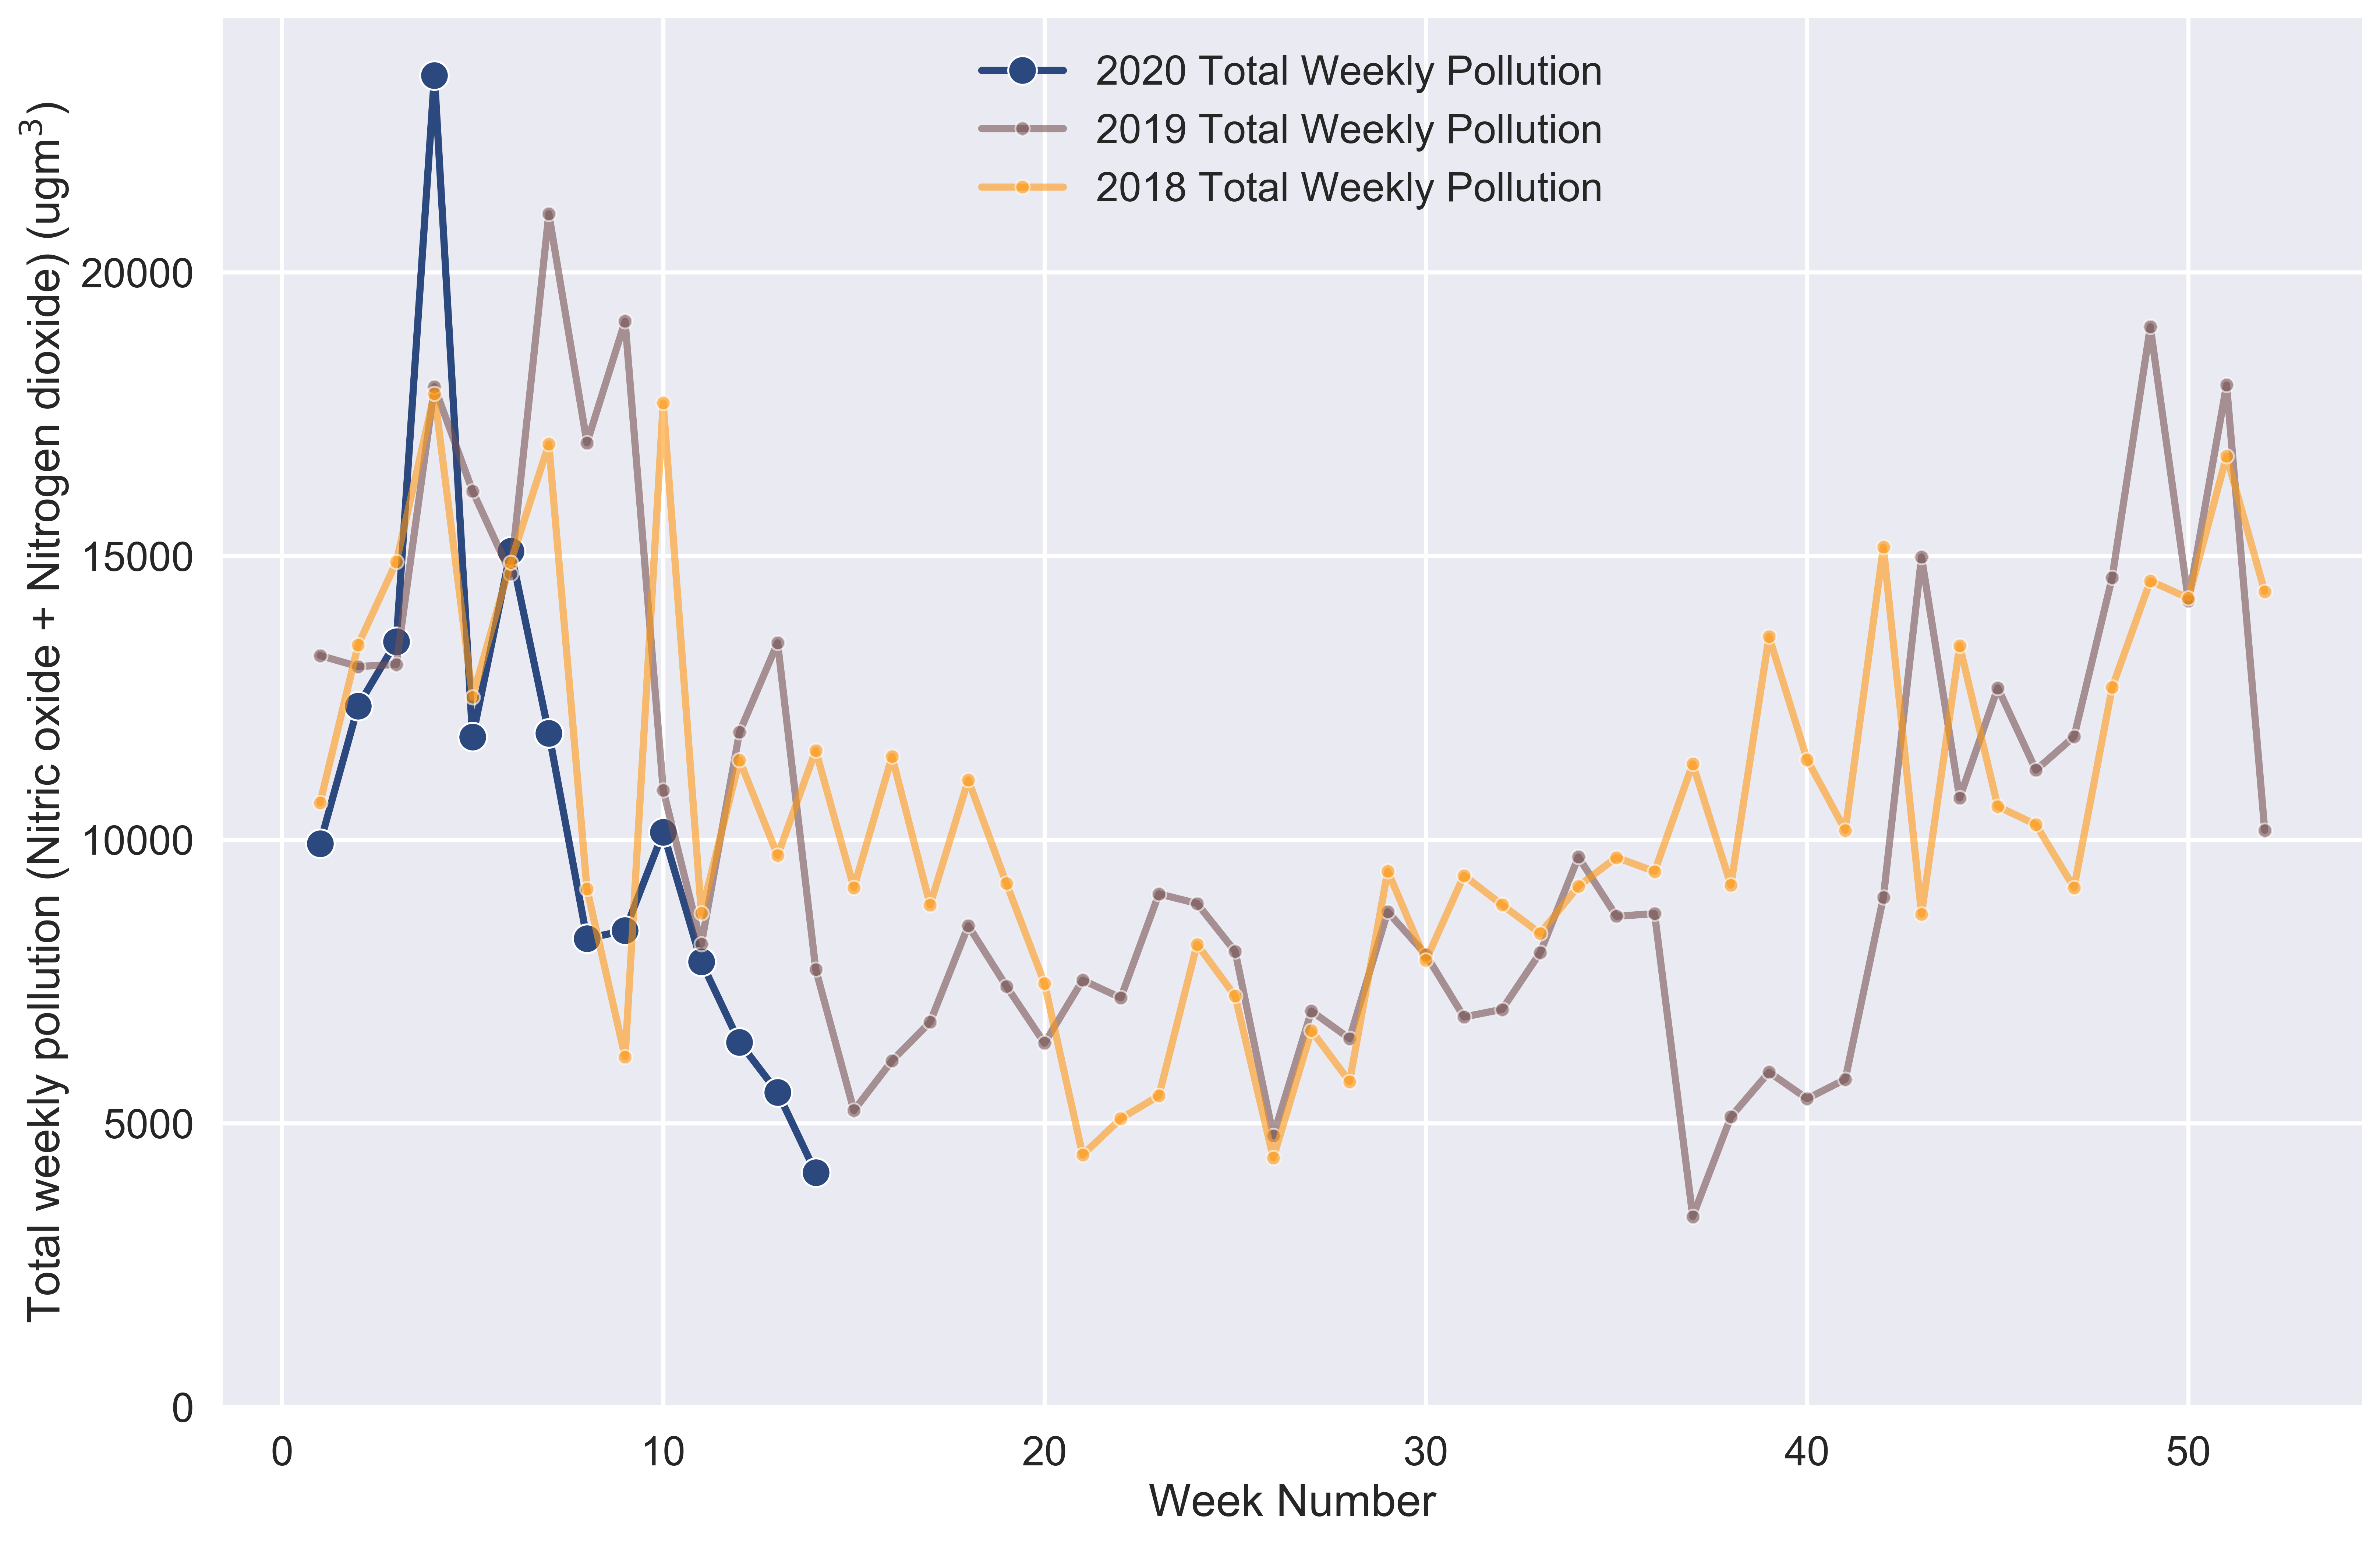

In [93]:
# First, make pivot table
df_all = df_all.loc['2017-01-01':'2020-04-05'] # so it only plots full weeks
weekly = df_all.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')


x = plt.figure(figsize=(15,10),dpi=500)
x = sns.lineplot(x=pivoted.index,y=pivoted['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
#sns.lineplot(x=pivoted.index,y=pivoted['2017'],label='2017 Total Weekly Pollution',
#             alpha=0.6,color='#EC4E20',marker='.',ci=None)

# plot stylings
plt.legend(loc='upper center')
plt.ylabel('Total weekly pollution (Nitric oxide + Nitrogen dioxide) (ugm$^3$)')
plt.xlabel('Week Number')
x.set_ylim(0,None)

plt.savefig('weekly_over_3_years.png')

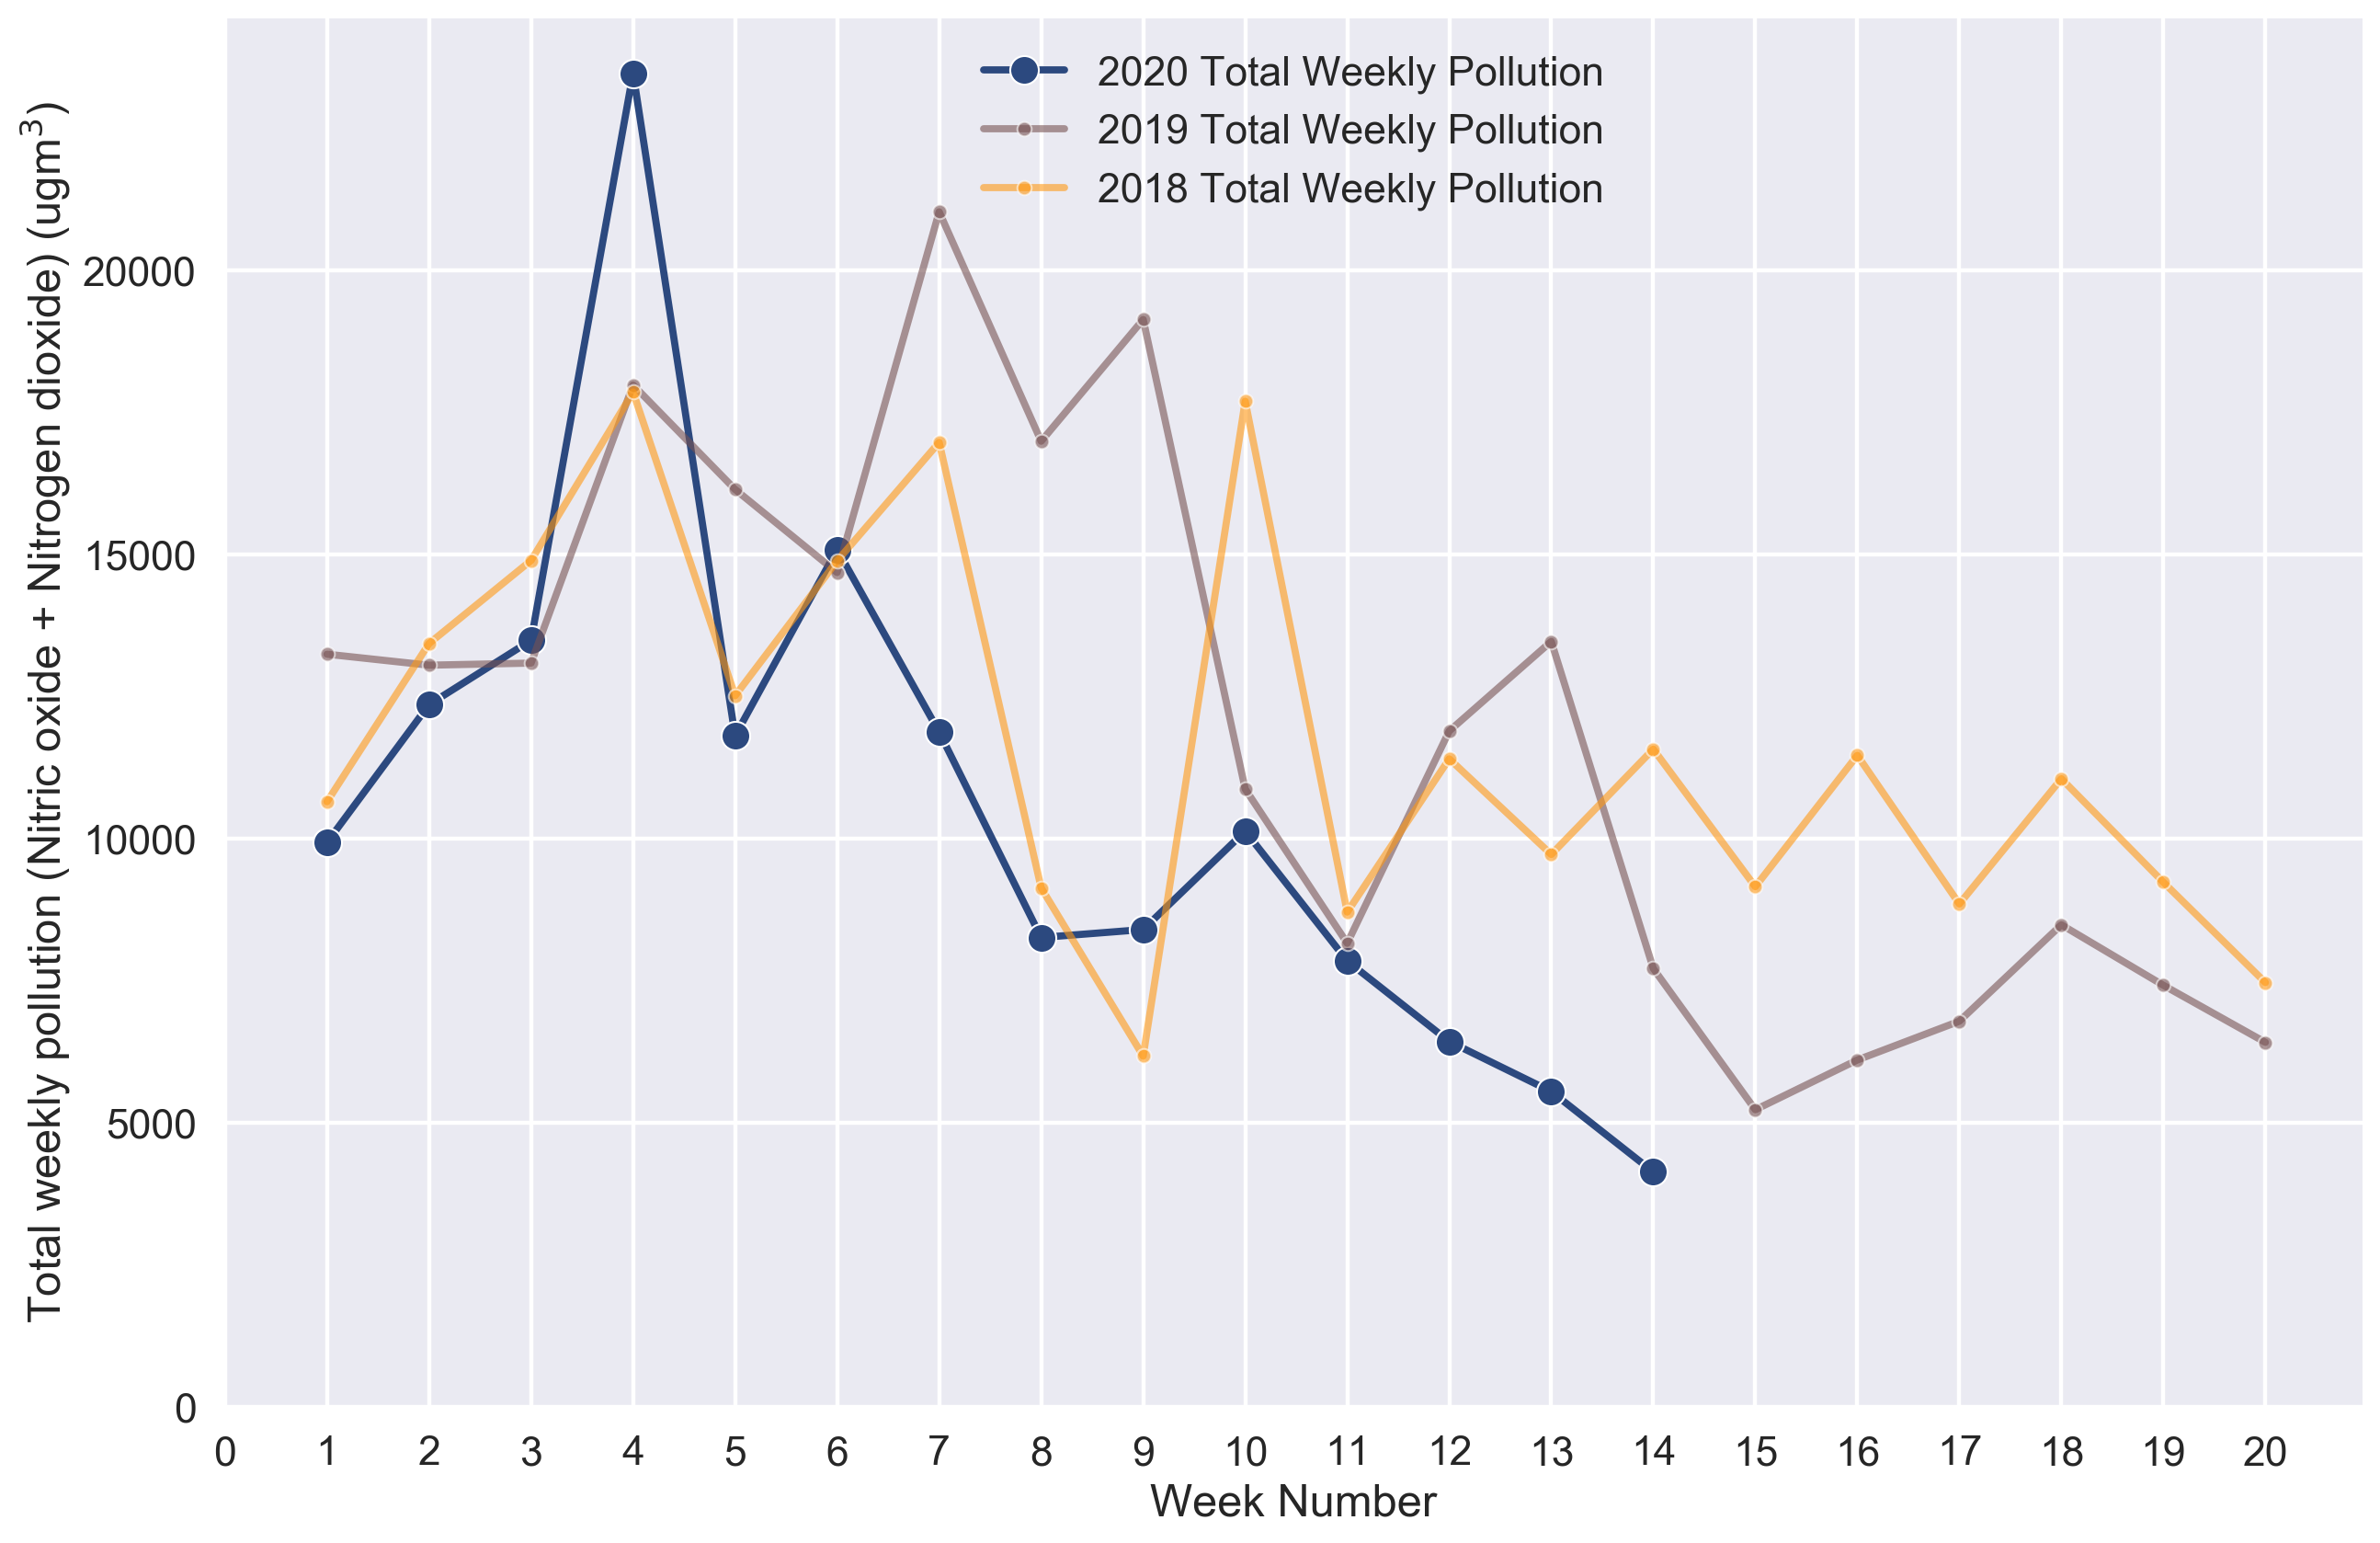

In [30]:
# First, make pivot table
df_all = df_all.loc['2017-01-01':'2020-04-05'] # so it only plots full weeks
weekly = df_all.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']
pivoted = pivoted.iloc[0:20]
# plotting data
x = plt.figure(figsize=(15,10),dpi=200)
x = sns.lineplot(x=pivoted.index,y=pivoted['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
#sns.lineplot(x=pivoted.index,y=pivoted['2017'],label='2017 Total Weekly Pollution',
#             alpha=0.6,color='#EC4E20',marker='.',ci=None)

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center')
plt.ylabel('Total weekly pollution (Nitric oxide + Nitrogen dioxide) (ugm$^3$)')
plt.xlabel('Week Number')
x.set_ylim(0,None)
plt.xticks(np.arange(21),np.arange(21))
plt.savefig('weekly_over_3_years_limited.png')

# Weekly Pivot

In [117]:
# Make pivot table with specific date range so I'm only looking at full weeks
df_all_ = df_all.loc['2017-01-01':'2020-04-05'] 
weekly = df_all_.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# new columns
pivoted['% of 2019'] = (pivoted['2020']/pivoted['2019'])*100
pivoted['% change'] = (pivoted['2020']/pivoted['2019']-1)*100

#median of previous years
z = pivoted.loc[:,['2017','2018','2019']].median(axis=1)
pivoted['Median Over Previous Years'] = z

# median calculation columns
pivoted['% Of Median'] = (pivoted['2020']/pivoted['Median Over Previous Years'])*100
pivoted['% Change From Median'] = ((pivoted['2020']/pivoted['Median Over Previous Years'])-1)*100

# neater dataframe
pivoted_clean = pivoted.iloc[:,[6,3,7,8]]
pivoted_clean.head(20)

Median Over Previous Years         2020  % Of Median  \
Date Time                                                         
1                         10648.36125   9933.16364    93.283496   
2                         13051.44925  12357.81916    94.685417   
3                         13088.40537  13489.29181   103.062913   
4                         17983.94996  23472.47084   130.518996   
5                         12513.92041  11808.34109    94.361644   
6                         14681.96571  15088.20791   102.766947   
7                         16973.35724  11875.23210    69.963955   
8                         11388.30904   8258.59008    72.518142   
9                         13554.37781   8399.01153    61.965305   
10                        13651.88163  10131.08396    74.210166   
11                         8705.12226   7845.98853    90.130710   
12                        11403.13346   6428.17302    56.371988   
13                        12014.27699   5547.85653    46.177198   
14                        11573.52484   4132.29337    35.704709   
15                         9152.72802          NaN          NaN   
16                         8747.69068          NaN          NaN   
17                         8848.92023          NaN          NaN   
18                         8482.39126          NaN          NaN   
19                         7717.07874          NaN          NaN   
20                         7465.59599          NaN          NaN   

           % Change From Median  
Date Time                        
1                     -6.716504  
2                     -5.314583  
3                      3.062913  
4                     30.518996  
5                     -5.638356  
6                      2.766947  
7                    -30.036045  
8                    -27.481858  
9                    -38.034695  
10                   -25.789834  
11                    -9.869290  
12                   -43.628012  
13                   -53.822802  
14                   -64.295291  
15                          NaN  
16                          NaN  
17                          NaN  
18                          NaN  
19                          NaN  
20                          NaN

Text(0.5, 1, 'Total Pollution Measured Per Week Of Each Year')

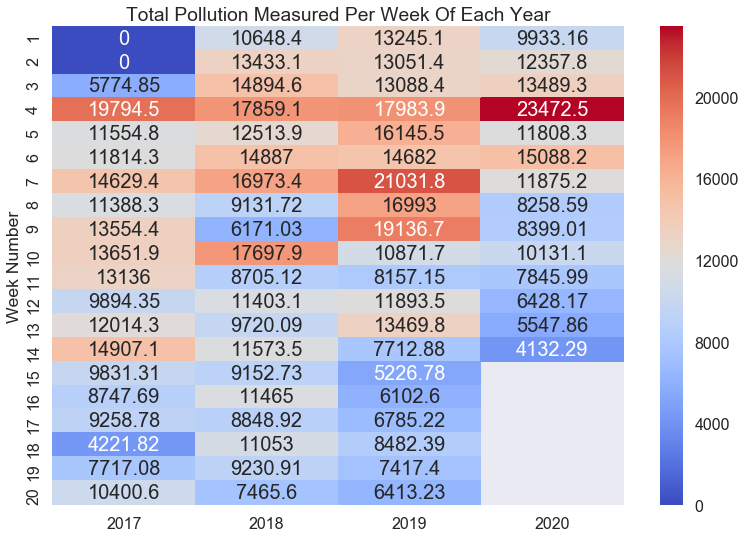

In [61]:
ax = sns.heatmap(pivoted[['2017','2018','2019','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Week Number')
title('Total Pollution Measured Per Week Of Each Year')

Text(0.5, 1, '2020 Weekly Pollution Compared To Median Pollution of Previous 3 Years')

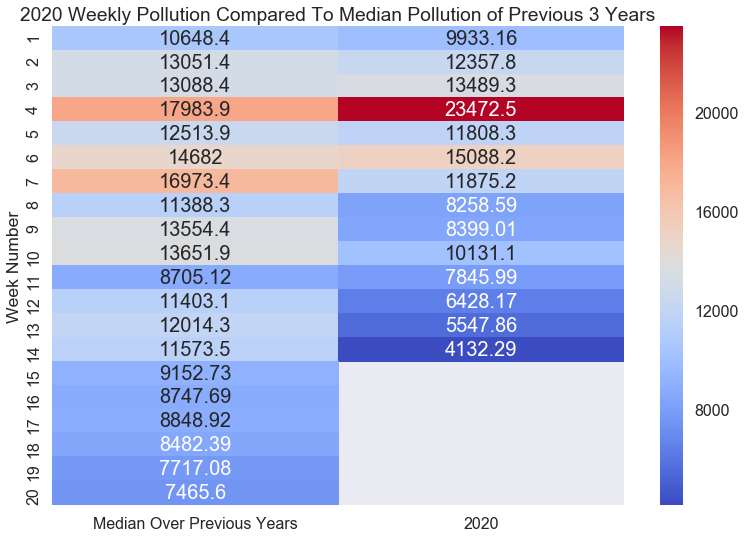

In [144]:
pivoted_clean_ = pivoted_clean.iloc[:20,:]

ax = sns.heatmap(pivoted_clean_[['Median Over Previous Years','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Week Number')
title('2020 Weekly Pollution Compared To Median Pollution of Previous 3 Years')
#xticks(np.arange(2),['Median Total Pollution Of 2017, 2018 and 2019','2020 Weekly Total Pollution'])

# Monthly Pivot

In [123]:
# Monthly pivot table with specific date range so only full months are measured
df_all_ = df_all.loc['2017-01-01':'2020-03-31'] 
monthly = df_all_.resample('M').sum()
month_piv = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
month_piv.columns=['2017','2018','2019','2020']

# new columns
month_piv['% of 2019'] = (month_piv['2020']/month_piv['2019'])*100
month_piv['% change'] = ((month_piv['2020']/month_piv['2019'])-1)*100

# median of previous years
z = month_piv.loc[:,['2017','2018','2019']].median(axis=1)
month_piv['Median Of Previous Years'] = z

# median columns 
month_piv['% Of Median'] = (month_piv['2020']/month_piv['Median Of Previous Years'])*100
month_piv['% Change From Median'] = ((month_piv['2020']/month_piv['Median Of Previous Years'])-1)*100

# cleaned up dataframe 
month_piv_clean = month_piv.iloc[:,[6,3,7,8]]
month_piv_clean

Median Of Previous Years         2020  % Of Median  \
Date Time                                                       
1                       63018.95106  65301.76898   103.622431   
2                       51400.74592  45423.20749    88.370717   
3                       50098.27769  31812.27883    63.499745   
4                       42509.04851          NaN          NaN   
5                       32834.78904          NaN          NaN   
6                       32496.47416          NaN          NaN   
7                       32978.27321          NaN          NaN   
8                       38861.70214          NaN          NaN   
9                       44477.42794          NaN          NaN   
10                      51957.30909          NaN          NaN   
11                      53822.11581          NaN          NaN   
12                      66894.90382          NaN          NaN   

           % Change From Median  
Date Time                        
1                      3.622431  
2                    -11.629283  
3                    -36.500255  
4                           NaN  
5                           NaN  
6                           NaN  
7                           NaN  
8                           NaN  
9                           NaN  
10                          NaN  
11                          NaN  
12                          NaN

Text(0.5, 1, 'Total Pollution Measured Per Month Of Each Year')

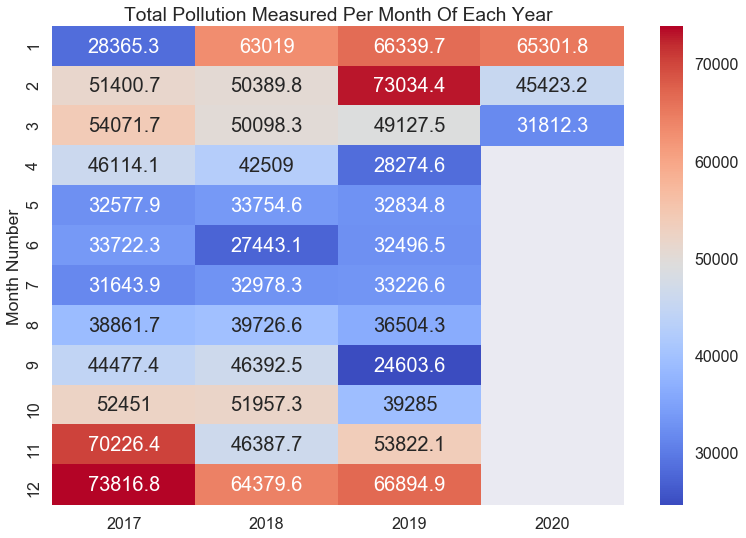

In [62]:
ax = sns.heatmap(month_piv[['2017','2018','2019','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Month Number')
title('Total Pollution Measured Per Month Of Each Year')

Text(0.5, 1, '2020 Monthly Pollution Compared To Median Pollution of Previous 3 Years')

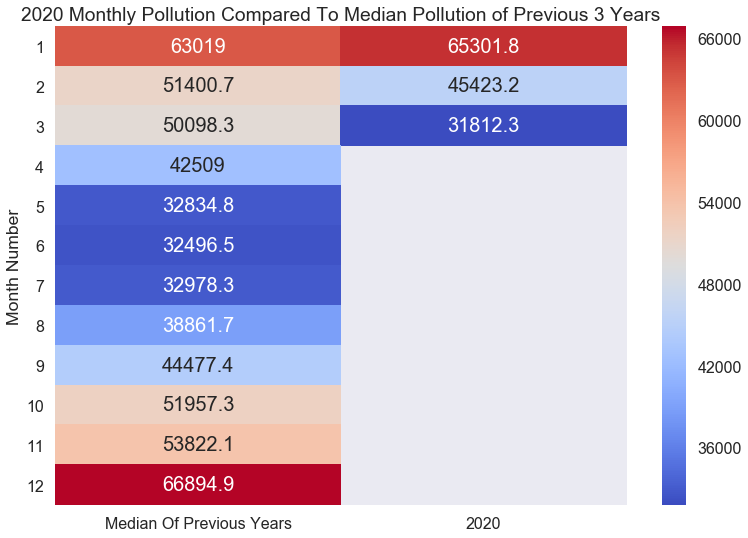

In [141]:
ax = sns.heatmap(month_piv_clean[['Median Of Previous Years','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Month Number')
#yticks(np.arange(12),['Jan','Feb','Mar','Apr','Jun','July','Aug','Sep','Oct','Nov','Dec'])
yticks(rotation=0)
title('2020 Monthly Pollution Compared To Median Pollution of Previous 3 Years')

# Total Emissions for 1 month of each year


In [13]:
def month_comparison(month_str,years_to_plot):
    '''
    month_str = month in two digit format i.e. March = 03
    years_to_plot = integer. If 4, plot all 4 years, if 3 plot most recent 3 years etc
    '''
    months_with_28_days=['2','02']
    months_with_31_days=['1','01','3','03','5','05','7','07','8','08','10','12']
    months_with_30_days=['4','04','6','06','9','09','11']
    
    if month_str in(months_with_28_days):
        days_in_month = 28
    elif month_str in(months_with_31_days):
        days_in_month = 31
    elif month_str in(months_with_30_days):
        days_in_month=30
        
    # getting month name for title of plot
    monthinteger = int(month_str)
    month = calendar.month_name[monthinteger]
    
    month_17 = df_all.loc['2017-{}-01'.format(month_str):'2017-{}-{}'.format(month_str,days_in_month)] 
    month_18 = df_all.loc['2018-{}-01'.format(month_str):'2018-{}-{}'.format(month_str,days_in_month)]
    month_19 = df_all.loc['2019-{}-01'.format(month_str):'2019-{}-{}'.format(month_str,days_in_month)]
    month_20 = df_all.loc['2020-{}-01'.format(month_str):'2020-{}-{}'.format(month_str,days_in_month)]

    month_17_no = month_17['Nitric oxide'].sum()
    month_17_nd = month_17['Nitrogen dioxide'].sum()

    month_18_no = month_18['Nitric oxide'].sum()
    month_18_nd = month_18['Nitrogen dioxide'].sum()

    month_19_no = month_19['Nitric oxide'].sum()
    month_19_nd = month_19['Nitrogen dioxide'].sum()

    month_20_no = month_20['Nitric oxide'].sum()
    month_20_nd = month_20['Nitrogen dioxide'].sum()

    # Making a new dataframe to plot
    data = {'{}-2017'.format(month_str):[month_17_no,month_17_nd],
           '{}-2018'.format(month_str):[month_18_no, month_18_nd],
            '{}-2019'.format(month_str):[month_19_no, month_19_nd],
            '{}-2020'.format(month_str):[month_20_no, month_20_nd]}

    df = pd.DataFrame(data)
    df.index = ['Nitric Oxide','Nitrogen Dioxide']
    
    
    if years_to_plot==4:
        df_=df
    elif years_to_plot==3:
        df_=df[['{}-2018'.format(month_str),'{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==2:
        df_=df[['{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==1:
        df_=df[['{}-2020'.format(month_str)]]
    
    #plt.style.use('seaborn-poster')
    plt.style.use('tableau-colorblind10')
    df_.plot.bar(figsize=[15,10])
    plt.title('Total Emissions In {} of Each Year'.format(month))

    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')

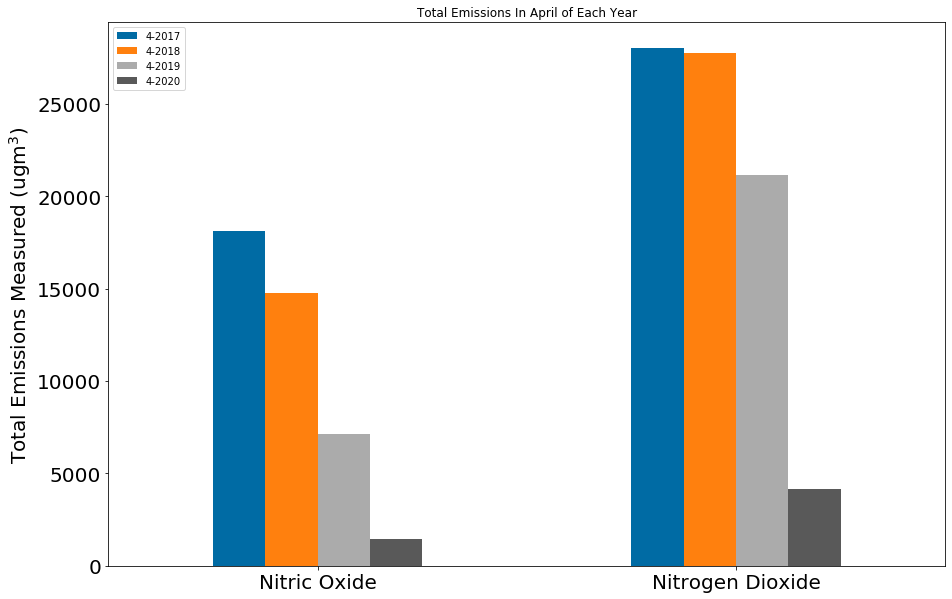

In [14]:
month_comparison(month_str='4',years_to_plot=4)

# add specifying the years to analyse too 

# Looking at different features like weekday, weather etc
- Currently have week, day of week, quarter, weekday or weekend

In [137]:
df_all

Nitric oxide  Nitrogen dioxide  \
Date Time                                             
2017-01-01 01:00:00           NaN               NaN   
2017-01-01 02:00:00           NaN               NaN   
2017-01-01 03:00:00           NaN               NaN   
2017-01-01 04:00:00           NaN               NaN   
2017-01-01 05:00:00           NaN               NaN   
...                           ...               ...   
2020-04-03 20:00:00       5.86231          28.68750   
2020-04-03 21:00:00       3.36771          27.92250   
2020-04-03 22:00:00       4.98920          22.37625   
2020-04-03 23:00:00       3.24298          22.75875   
2020-04-04 00:00:00       3.24298          25.05375   

                     Nitrogen oxides as nitrogen dioxide           Date Time  \
Date Time                                                                      
2017-01-01 01:00:00                                  NaN 2017-01-01 01:00:00   
2017-01-01 02:00:00                                  NaN 2017-01-01 02:00:00   
2017-01-01 03:00:00                                  NaN 2017-01-01 03:00:00   
2017-01-01 04:00:00                                  NaN 2017-01-01 04:00:00   
2017-01-01 05:00:00                                  NaN 2017-01-01 05:00:00   
...                                                  ...                 ...   
2020-04-03 20:00:00                             37.67625 2020-04-03 20:00:00   
2020-04-03 21:00:00                             33.08625 2020-04-03 21:00:00   
2020-04-03 22:00:00                             30.02625 2020-04-03 22:00:00   
2020-04-03 23:00:00                             27.73125 2020-04-03 23:00:00   
2020-04-04 00:00:00                             30.02625 2020-04-04 00:00:00   

                     Week  Day Of Week  Quarter Weekday Or Weekend     Total  
Date Time                                                                     
2017-01-01 01:00:00    52            6        1            Weekend       NaN  
2017-01-01 02:00:00    52            6        1            Weekend       NaN  
2017-01-01 03:00:00    52            6        1            Weekend       NaN  
2017-01-01 04:00:00    52            6        1            Weekend       NaN  
2017-01-01 05:00:00    52            6        1            Weekend       NaN  
...                   ...          ...      ...                ...       ...  
2020-04-03 20:00:00    14            4        2            Weekday  34.54981  
2020-04-03 21:00:00    14            4        2            Weekday  31.29021  
2020-04-03 22:00:00    14            4        2            Weekday  27.36545  
2020-04-03 23:00:00    14            4        2            Weekday  26.00173  
2020-04-04 00:00:00    14            5        2            Weekend  28.29673  

[28536 rows x 9 columns]

Text(0.5, 0, '')

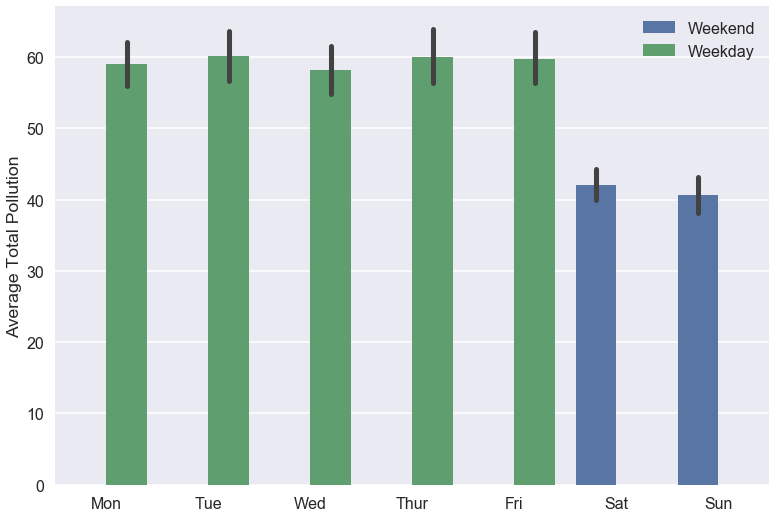

In [152]:
sns.barplot(x='Day Of Week',y='Total',data=df_2017,hue = 'Weekday Or Weekend')
plt.xticks(np.arange(7),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.legend(title=None)
plt.ylabel('Average Total Pollution')
## What are the units for this? Also I don't even know if it is doing an average
plt.xlabel('')

No handles with labels found to put in legend.


Text(0.5, 0, 'Quarter')

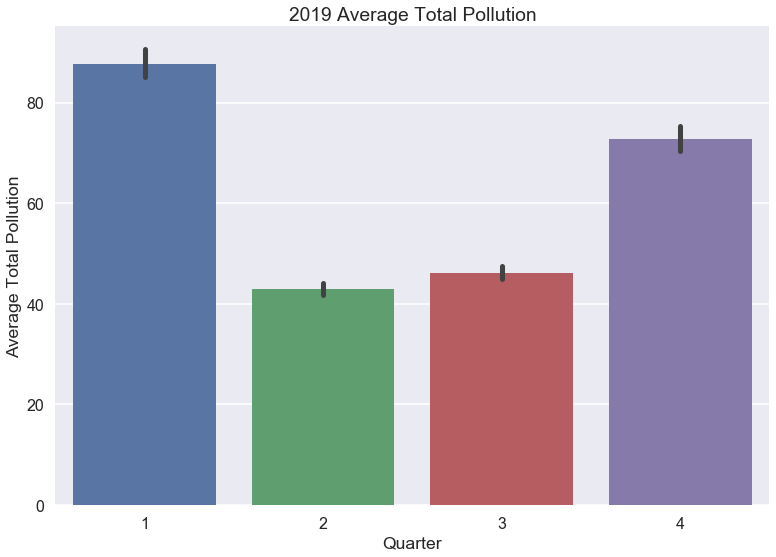

In [164]:
# how is this grouping them? Is it doing an average of hourly data?

sns.barplot(x='Quarter',y='Total',data=df_2019)
plt.legend(title=None)
plt.ylabel('Average Total Pollution')
plt.title('2019 Average Total Pollution')
## What are the units for this? Also I don't even know if it is doing an average
plt.xlabel('Quarter')

# Plotting months of all years next to each other 

<Figure size 18000x18000 with 0 Axes>

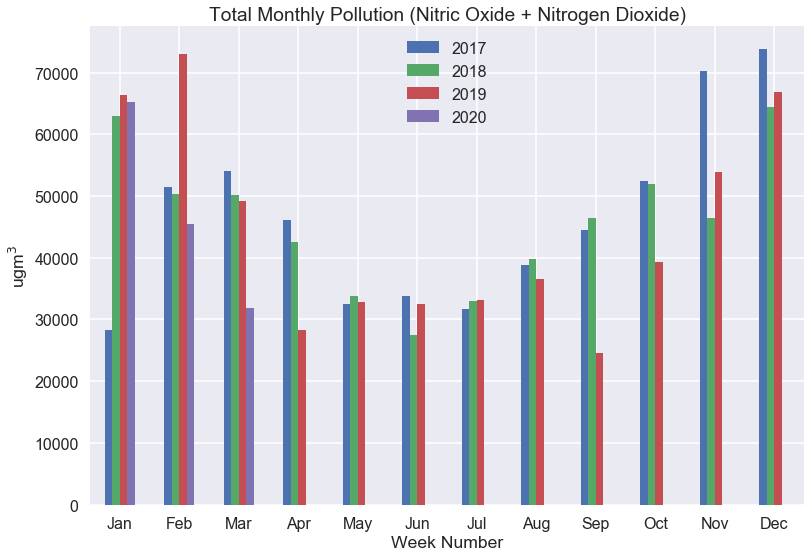

In [12]:
x = df_all.loc['2017-01-01':'2020-03-31'] # so it's only full months
# First, make pivot table
monthly = x.resample('M').sum()
pivoted = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')
plt.figure(figsize=(15,15),dpi=1200)
pivoted.plot(kind='bar')

# plot stylings
plt.title('Total Monthly Pollution (Nitric Oxide + Nitrogen Dioxide)')
plt.legend(loc='upper center')
plt.ylabel('ugm$^3$')
plt.xlabel('Week Number')
plt.xticks(rotation=0)
plt.xticks(np.arange(12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.savefig('Monthly Pollution.png')

# Following Udemy course

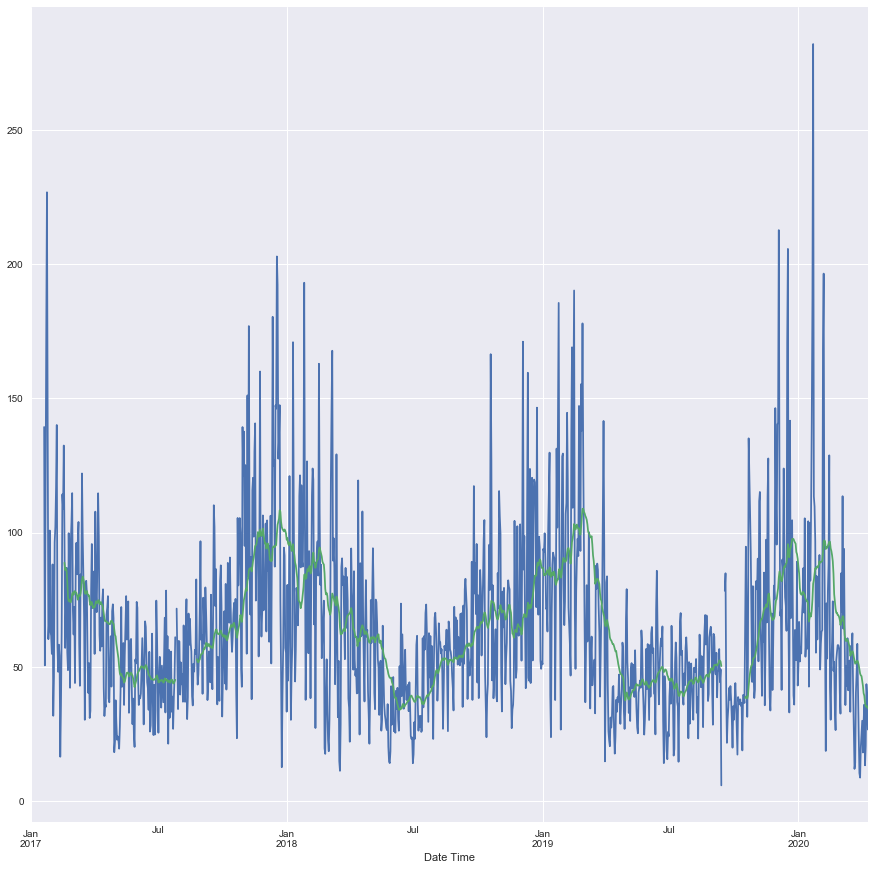

In [42]:
df_all['Total'].resample('D').mean().plot(figsize=[15,15])
daily = df_all.resample('D').mean()
daily.rolling(window=30).mean()['Total'].plot()

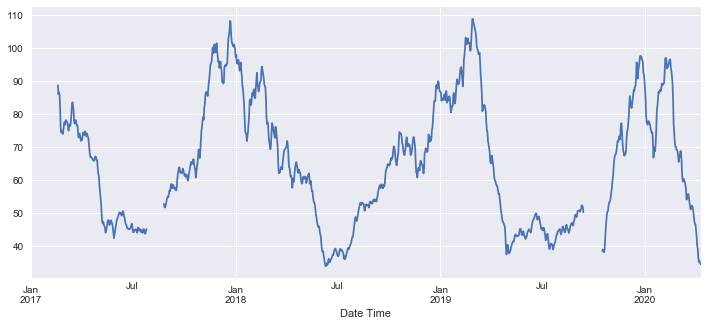

In [41]:
#df_all['Total'].resample('D').mean().plot(figsize=[12,5])
daily = df_all.resample('D').mean()
daily.rolling(window=30).mean()['Total'].plot(figsize=[12,5])